## **Social Distancing Detection Using DETECTRON2 and RCNNs**

#####This notebook contains a model built using Detectron2 (by FAIR), a SOTA (w.r.t maskrcnn-benchmark) framework for Object Detection. This project was carried out to integrate multiple object detection tasks like keypoint detection, instance segmentation, panoptic segementation and bounding box detection. To coalesce all these tasks into a useful project, a eucledian distance based social distancing model was developed and tested on custom dataset (from youtube). 

This notebook has two models: 

1. A model that predicts the keypoints and B-box using a Keypoint R-CNN and a Resnet-50 Backbone (for feature extraction). It's trained on COCO Dataset (Not Pascal VOC) 
2. A model that does what this notebook is intended for - Social Distancing Violation Prediction. Uses the same network as above. I've just tampered with the Bboxes and included a distance prediction between them. 

I've also added a succinct code fragment that directly works with videos using Baseline R-CNNs and its corresponding weights (from Resnet-50). But, this didn't perform well with overlapping frames and a lazy prediction visualizaton. The panoptic segmentation model hasn't been included since it isn't an absolute necessity, but is a very easy process of changing a couple of lines by choosing the right model and weights.  



---
#####References: 

1. Detectron2 by FAIR   -- https://github.com/facebookresearch/detectron2
2. Video considered     -- https://www.youtube.com/watch?v=WvhYuDvH17I&feature=youtu.be
3. Detectron2 Model Zoo -- https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md


---
I have written detailed (and necessary) explanations above each code block that requires perusal. I've also written comments as required.     
Let's go!!!




---

---





In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#####Let's get our video from Youtube. We will prefer a video that's short enough to complete our task quickly, but fair enough that it can be generalized to other such videos. I've considered the video below! 

##Youtube Module


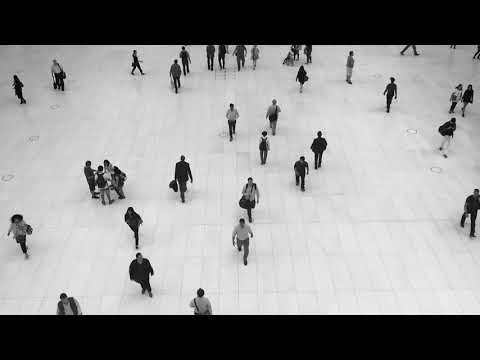

In [1]:
from IPython.display import YouTubeVideo                                    
YouTubeVideo('WvhYuDvH17I')                                                      #We pass the keywords after 'v=' in the url of an Youtube video to this function. 

In [2]:
!pip install youtube-dl                                                          #We use the library "youtube -dl" for this purpose. 

     |████████████████████████████████| 1.9MB 14.8MB/s 


In [3]:
!mkdir videos                           #A separate directory to store the video to be downloaded. 
!echo Directory Created!

Directory Created!


In [4]:
!youtube-dl -F https://www.youtube.com/watch?v=WvhYuDvH17I                       #This command is required to determine the extension for our download - .mkv, .mp4, .mp3, etc. 

[youtube] WvhYuDvH17I: Downloading webpage
[info] Available formats for WvhYuDvH17I:
format code  extension  resolution note
249          webm       audio only tiny    3k , opus @ 50k (48000Hz), 6.32KiB
250          webm       audio only tiny    3k , opus @ 70k (48000Hz), 6.32KiB
251          webm       audio only tiny    3k , opus @160k (48000Hz), 6.32KiB
140          m4a        audio only tiny  130k , m4a_dash container, mp4a.40.2@128k (44100Hz), 217.24KiB
278          webm       256x144    144p   95k , webm container, vp9, 25fps, video only, 155.76KiB
160          mp4        256x144    144p   97k , avc1.4d400c, 25fps, video only, 146.41KiB
133          mp4        426x240    240p  171k , avc1.4d4015, 25fps, video only, 259.70KiB
242          webm       426x240    240p  219k , vp9, 25fps, video only, 358.10KiB
134          mp4        640x360    360p  398k , avc1.4d401e, 25fps, video only, 614.83KiB
243          webm       640x360    360p  407k , vp9, 25fps, video only, 659.99KiB
135  

In [5]:
!youtube-dl -c -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4' https://www.youtube.com/watch?v=WvhYuDvH17I --output "video1.%(ext)s"
!cp video1.mp4 /content/videos 
!rm -r /content/video1.mp4 

!echo Video Downloaded! Please check 'videos' directory. 

[youtube] WvhYuDvH17I: Downloading webpage
[download] Destination: video1.f136.mp4
[download] 100% of 1.80MiB in 00:00
[download] Destination: video1.f140.m4a
[download] 100% of 217.24KiB in 00:00
[ffmpeg] Merging formats into "video1.mp4"
Deleting original file video1.f136.mp4 (pass -k to keep)
Deleting original file video1.f140.m4a (pass -k to keep)
Video Downloaded! Please check videos directory.


#####We now split the video into frames i.e., into images. This is necessary since R-CNNs process inputs image by image. We can then join back all these output images into a video again.

In [6]:
import cv2

!rm -r frames_for_keypoints+Bbox/*                                               #This command is for iterations > 1, so ignore the error message "No such file or directory"
!rm -r frames_for_socialdistance/*                                               #Same as above
!mkdir frames_for_keypoints+Bbox                                                 #This directory is to store our frames for keypoint and bouding box detections.  
!mkdir frames_for_socialdistance                                                 #This directory is to store our frames for social distancing violation detection.

#specify path to video
video = "/content/videos/video1.mp4"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

#Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completedframes_for_keypoints+Bbox/
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite("frames_for_keypoints+Bbox/"+str(cnt)+".png", frame)
    cnt=cnt+1
    if(cnt==750):
      break

  # Break the loop
  else: 
    break

rm: cannot remove 'frames_for_keypoints+Bbox/*': No such file or directory
rm: cannot remove 'frames_for_socialdistance/*': No such file or directory


In [7]:
#This is to make a copy of our frames for frames_for_socialdistance directory (Used later)

!cp -r frames_for_keypoints+Bbox/* frames_for_socialdistance                     

In [8]:
#How much frames per second has been acquired by us? 

FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

25.0


###DETECTRON2

---
#####Detectron2 is powered by Pytorch. The original Detectron was implemented in Caffe2. PyTorch provides a more intuitive imperative programming model that allows researchers and practitioners to iterate more rapidly on model design and experiments. Plus, we can perform better deep learning by leveraging Pytorch utilities. Amazing! 



In [9]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 16.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=9a0231715fb06052747e9c4e6b672dd4dc45fcb73acbc54624a73d523cddf18c
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [10]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions

import torch
assert torch.__version__.startswith("1.7")                                       #version check 

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 734kB/s 
     |████████████████████████████████| 2.2MB 30.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20210115-cp36-none-any.whl size=40892 sha256=1481cb4b30019a0d85ebc56e55dc589f750486720b1cf6ee2442411de9e3ba56
  Stored in directory: /root/.cache/pip/wheels/cc/0f/bc/fb742771f4a877f1211dd6ed36283b0db9c0ceb2b409b4a039
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10508 sha256=a648a7c3e62ee397a7d2afd50e20336d3943ce6cb014c08ff8495331504b0509
  Stored in directory: /root/.cache/pip/wheels/9e/01/e4/1b68f5a2a6b9450ea4246d91840a77e1169f7d4722d76bbc47
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.

In [11]:
exit(0)                                                                           #To restart runtime for installation completion. Give it 5 seconds. 

In [1]:
#This will take a few mins ... 

!git clone https://github.com/facebookresearch/detectron2.git                     #Git cloning Detectron2. This is to use its utilities. 
!cd detectron2 && python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'   #To change our working directory to detectron2 and installation. 

Cloning into 'detectron2'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9920 (delta 0), reused 1 (delta 0), pack-reused 9915
Receiving objects: 100% (9920/9920), 3.90 MiB | 27.74 MiB/s, done.
Resolving deltas: 100% (7313/7313), done.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-sspdwbd3
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-sspdwbd3
  Created wheel for detectron2: filename=detectron2-0.3-cp36-cp36m-linux_x86_64.whl size=5490816 sha256=e73d6f1e392a63af7a5f56d21540a69dc99843fd25553dc2dbda6587fb08d555
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfy2m_ga/wheels/33/ac/bb/5ef90585c21c67e2f0b6aae55ec6b43017ad57af33d5f4c339
Successfully built detectron2


In [2]:
!apt install python3-opencv                                                         # the one pre-installed has some issues. Hence, doing it again. 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  python3-opencv
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 534 kB of archives.
After this operation, 2,941 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 python3-opencv amd64 3.2.0+dfsg-4ubuntu0.1 [534 kB]
Fetched 534 kB in 1s (912 kB/s)
Selecting previously unselected package python3-opencv.
(Reading database ... 146364 files and directories currently installed.)
Preparing to unpack .../python3-opencv_3.2.0+dfsg-4ubuntu0.1_amd64.deb ...
Unpacking python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Setting up python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...


In [3]:
#Importing Libraries 

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import random

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import keypoints

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
!pip install av                                                                   #This library is necessary for further video dependencies 

     |████████████████████████████████| 36.9MB 88kB/s 


##MODEL 1 - BBOX + KEYPOINTS DETECTION 

---
I've used Keypoints R-CNN to detect 17 keypoints (as per COCO) and trace them throughout the video (Object Tracking). 


In [5]:
from google.colab.patches import cv2_imshow                                        #cv2.imshow is deprecated. Hence, I've imported cv2_imshow. 

(720, 1280, 3)


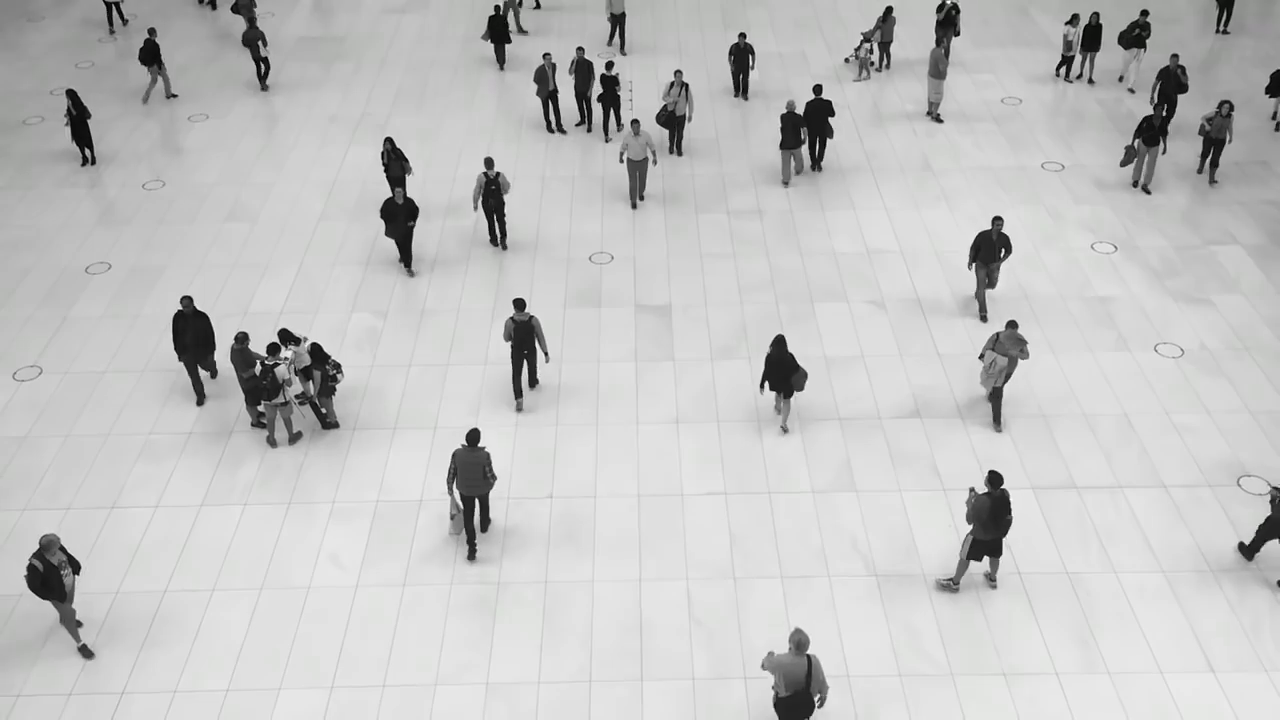

The above list shows the resolution of the image, along with its color composition. Since the video is Grayscale itself, we see it as such.


In [6]:
#Showing the first frame we obtained from the video. Visualization helps to ascertain work done till now and paves a way to move forwared :) 

import cv2                                                                       #Sometimes, there pops an error which says cv2 isn't installed. So, imported here just to be on the safer side. 
im = cv2.imread("frames_for_keypoints+Bbox/0.png")
print(im.shape)

cv2_imshow(im)

!echo The above list shows the resolution of the image, along with its color composition. Since the video is Grayscale itself, we see it as such. 

##A little Deviation here ... 
####Experimental Cell Below! 

Tampered with the Detectron2 Visualizer class to mask images without bounding boxes. But, alas, it has a relative import for random colors. In layman terms, this is a pandora's box. But, I've kept this code just to peruse it completely. If useless, will discard soon. 

In [ ]:
'''

# Copyright (c) Facebook, Inc. and its affiliates.
import colorsys
import logging
import math
import numpy as np
from enum import Enum, unique
import cv2
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import pycocotools.mask as mask_util
import torch
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image
import PIL

from detectron2.data import MetadataCatalog
from detectron2.structures import BitMasks, Boxes, BoxMode, Keypoints, PolygonMasks, RotatedBoxes
from detectron2.utils.file_io import PathManager

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__all__ = ['cv2_imshow', 'cv_imshow']

from IPython import display


def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks.
  Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
      (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color
      image.
  """
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display.display(PIL.Image.fromarray(a))


cv_imshow = cv2_imshow

__all__ = ["colormap", "random_color"]

# fmt: off
# RGB:
_COLORS = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.857, 0.857, 0.857,
        1.000, 1.000, 1.000
    ]
).astype(np.float32).reshape(-1, 3)
# fmt: on


def colormap(rgb=False, maximum=255):
    """
    Args:
        rgb (bool): whether to return RGB colors or BGR colors.
        maximum (int): either 255 or 1
    Returns:
        ndarray: a float32 array of Nx3 colors, in range [0, 255] or [0, 1]
    """
    assert maximum in [255, 1], maximum
    c = _COLORS * maximum
    if not rgb:
        c = c[:, ::-1]
    return c


def random_color(rgb=False, maximum=255):
    """
    Args:
        rgb (bool): whether to return RGB colors or BGR colors.
        maximum (int): either 255 or 1
    Returns:
        ndarray: a vector of 3 numbers
    """
    idx = np.random.randint(0, len(_COLORS))
    ret = _COLORS[idx] * maximum
    if not rgb:
        ret = ret[::-1]
    return ret


if __name__ == "__main__":
    import cv2

    size = 100
    H, W = 10, 10
    canvas = np.random.rand(H * size, W * size, 3).astype("float32")
    for h in range(H):
        for w in range(W):
            idx = h * W + w
            if idx >= len(_COLORS):
                break
            canvas[h * size : (h + 1) * size, w * size : (w + 1) * size] = _COLORS[idx]
    cv2_imshow(canvas)
    cv2.waitKey(0)


logger = logging.getLogger(__name__)

__all__ = ["ColorMode", "VisImage", "Visualizer"]


_SMALL_OBJECT_AREA_THRESH = 1000
_LARGE_MASK_AREA_THRESH = 120000
_OFF_WHITE = (1.0, 1.0, 240.0 / 255)
_BLACK = (0, 0, 0)
_RED = (1.0, 0, 0)

_KEYPOINT_THRESHOLD = 0.05

@unique
class ColorMode(Enum):
    """
    Enum of different color modes to use for instance visualizations.
    """

    IMAGE = 0
    """
    Picks a random color for every instance and overlay segmentations with low opacity.
    """
    SEGMENTATION = 1
    """
    Let instances of the same category have similar colors
    (from metadata.thing_colors), and overlay them with
    high opacity. This provides more attention on the quality of segmentation.
    """
    IMAGE_BW = 2
    """
    Same as IMAGE, but convert all areas without masks to gray-scale.
    Only available for drawing per-instance mask predictions.
    """


def _create_text_labels(classes, scores, class_names, is_crowd=None):
    """
    Args:
        classes (list[int] or None):
        scores (list[float] or None):
        class_names (list[str] or None):
        is_crowd (list[bool] or None):

    Returns:
        list[str] or None
    """
    labels = None
    if classes is not None and class_names is not None and len(class_names) > 0:
        labels = [class_names[i] for i in classes]
    if scores is not None:
        if labels is None:
            labels = ["{:.0f}%".format(s * 100) for s in scores]
        else:
            labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
    if is_crowd is not None:
        labels = [l + ("|crowd" if crowd else "") for l, crowd in zip(labels, is_crowd)]
    return labels

class VisImage:
    def __init__(self, img, scale=1.0):
        """
        Args:
            img (ndarray): an RGB image of shape (H, W, 3).
            scale (float): scale the input image
        """
        self.img = img
        self.scale = scale
        self.width, self.height = img.shape[1], img.shape[0]
        self._setup_figure(img)

    def _setup_figure(self, img):
        """
        Args:
            Same as in :meth:`__init__()`.

        Returns:
            fig (matplotlib.pyplot.figure): top level container for all the image plot elements.
            ax (matplotlib.pyplot.Axes): contains figure elements and sets the coordinate system.
        """
        fig = mplfigure.Figure(frameon=False)
        self.dpi = fig.get_dpi()
        # add a small 1e-2 to avoid precision lost due to matplotlib's truncation
        # (https://github.com/matplotlib/matplotlib/issues/15363)
        fig.set_size_inches(
            (self.width * self.scale + 1e-2) / self.dpi,
            (self.height * self.scale + 1e-2) / self.dpi,
        )
        self.canvas = FigureCanvasAgg(fig)
        # self.canvas = mpl.backends.backend_cairo.FigureCanvasCairo(fig)
        ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
        ax.axis("off")
        # Need to imshow this first so that other patches can be drawn on top
        ax.imshow(img, extent=(0, self.width, self.height, 0), interpolation="nearest")

        self.fig = fig
        self.ax = ax

class Visualizer:
    """
    Visualizer that draws data about detection/segmentation on images.

    It contains methods like `draw_{text,box,circle,line,binary_mask,polygon}`
    that draw primitive objects to images, as well as high-level wrappers like
    `draw_{instance_predictions,sem_seg,panoptic_seg_predictions,dataset_dict}`
    that draw composite data in some pre-defined style.

    Note that the exact visualization style for the high-level wrappers are subject to change.
    Style such as color, opacity, label contents, visibility of labels, or even the visibility
    of objects themselves (e.g. when the object is too small) may change according
    to different heuristics, as long as the results still look visually reasonable.

    To obtain a consistent style, you can implement custom drawing functions with the
    abovementioned primitive methods instead. If you need more customized visualization
    styles, you can process the data yourself following their format documented in
    tutorials (:doc:`/tutorials/models`, :doc:`/tutorials/datasets`). This class does not
    intend to satisfy everyone's preference on drawing styles.

    This visualizer focuses on high rendering quality rather than performance. It is not
    designed to be used for real-time applications.
    """

    # TODO implement a fast, rasterized version using OpenCV
    def __init__(self, img_rgb, metadata=None, scale=1.0, instance_mode=ColorMode.IMAGE):
        """
        Args:
            img_rgb: a numpy array of shape (H, W, C), where H and W correspond to
                the height and width of the image respectively. C is the number of
                color channels. The image is required to be in RGB format since that
                is a requirement of the Matplotlib library. The image is also expected
                to be in the range [0, 255].
            metadata (Metadata): image metadata.
            instance_mode (ColorMode): defines one of the pre-defined style for drawing
                instances on an image.
        """
        self.img = np.asarray(img_rgb).clip(0, 255).astype(np.uint8)
        if metadata is None:
            metadata = MetadataCatalog.get("__nonexist__")
        self.metadata = metadata
        self.output = VisImage(self.img, scale=scale)
        self.cpu_device = torch.device("cpu")

        # too small texts are useless, therefore clamp to 9
        self._default_font_size = max(
            np.sqrt(self.output.height * self.output.width) // 90, 10 // scale
        )
        self._instance_mode = instance_mode
   
    def draw_instance_predictions(self, predictions):
        """
        Draw instance-level prediction results on an image.

        Args:
            predictions (Instances): the output of an instance detection/segmentation
                model. Following fields will be used to draw:
                "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").

        Returns:
            output (VisImage): image object with visualizations.
        """
        boxes = None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]
        else:
            masks = None

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in classes
            ]
            alpha = 0.8
        else:
            colors = None
            alpha = 0.5

        if self._instance_mode == ColorMode.IMAGE_BW:
            self.output.img = self._create_grayscale_image(
                (predictions.pred_masks.any(dim=0) > 0).numpy()
                if predictions.has("pred_masks")
                else None
            )
            alpha = 0.3

        self.overlay_instances(
            masks=masks,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
        return self.output

    def _convert_keypoints(self, keypoints):
        if isinstance(keypoints, Keypoints):
            keypoints = keypoints.tensor
        keypoints = np.asarray(keypoints)
        return keypoints


    def get_output(self):
        """
        Returns:
            output (VisImage): the image output containing the visualizations added
            to the image.
        """
        return self.output


    def draw_dataset_dict(self, dic):
        """
        Draw annotations/segmentaions in Detectron2 Dataset format.

        Args:
            dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.

        Returns:
            output (VisImage): image object with visualizations.
        """
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [
                BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYXY_ABS)
                if len(x["bbox"]) == 4
                else x["bbox"]
                for x in annos
            ]

            colors = None
            category_ids = [x["category_id"] for x in annos]
            if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
                colors = [
                    self._jitter([x / 255 for x in self.metadata.thing_colors[c]])
                    for c in category_ids
                ]
            names = self.metadata.get("thing_classes", None)
            labels = _create_text_labels(
                category_ids,
                scores=None,
                class_names=names,
                is_crowd=[x.get("iscrowd", 0) for x in annos],
            )
            self.overlay_instances(
                labels=labels, boxes=boxes, masks=masks, keypoints=keypts, assigned_colors=colors
            )

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            with PathManager.open(dic["sem_seg_file_name"], "rb") as f:
                sem_seg = Image.open(f)
                sem_seg = np.asarray(sem_seg, dtype="uint8")
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)

        pan_seg = dic.get("pan_seg", None)
        if pan_seg is None and "pan_seg_file_name" in dic:
            with PathManager.open(dic["pan_seg_file_name"], "rb") as f:
                pan_seg = Image.open(f)
                pan_seg = np.asarray(pan_seg)
                from panopticapi.utils import rgb2id

                pan_seg = rgb2id(pan_seg)
        if pan_seg is not None:
            segments_info = dic["segments_info"]
            pan_seg = torch.Tensor(pan_seg)
            self.draw_panoptic_seg(pan_seg, segments_info, area_threshold=0, alpha=0.5)
        return self.output
    def overlay_instances(
        self,
        *,
        boxes=None,
        labels=None,
        masks=None,
        keypoints=None,
        assigned_colors=None,
        alpha=0.5
    ):
        """
        Args:
            boxes (Boxes, RotatedBoxes or ndarray): either a :class:`Boxes`,
                or an Nx4 numpy array of XYXY_ABS format for the N objects in a single image,
                or a :class:`RotatedBoxes`,
                or an Nx5 numpy array of (x_center, y_center, width, height, angle_degrees) format
                for the N objects in a single image,
            labels (list[str]): the text to be displayed for each instance.
            masks (masks-like object): Supported types are:

                * :class:`detectron2.structures.PolygonMasks`,
                  :class:`detectron2.structures.BitMasks`.
                * list[list[ndarray]]: contains the segmentation masks for all objects in one image.
                  The first level of the list corresponds to individual instances. The second
                  level to all the polygon that compose the instance, and the third level
                  to the polygon coordinates. The third level should have the format of
                  [x0, y0, x1, y1, ..., xn, yn] (n >= 3).
                * list[ndarray]: each ndarray is a binary mask of shape (H, W).
                * list[dict]: each dict is a COCO-style RLE.
            keypoints (Keypoint or array like): an array-like object of shape (N, K, 3),
                where the N is the number of instances and K is the number of keypoints.
                The last dimension corresponds to (x, y, visibility or score).
            assigned_colors (list[matplotlib.colors]): a list of colors, where each color
                corresponds to each mask or box in the image. Refer to 'matplotlib.colors'
                for full list of formats that the colors are accepted in.

        Returns:
            output (VisImage): image object with visualizations.
        """
        num_instances = None
        if boxes is not None:
            boxes = self._convert_boxes(boxes)
            num_instances = len(boxes)
        if masks is not None:
            masks = self._convert_masks(masks)
            if num_instances:
                assert len(masks) == num_instances
            else:
                num_instances = len(masks)
        if keypoints is not None:
            if num_instances:
                assert len(keypoints) == num_instances
            else:
                num_instances = len(keypoints)
            keypoints = self._convert_keypoints(keypoints)
        if labels is not None:
            assert len(labels) == num_instances
        if assigned_colors is None:
            assigned_colors = [random_color(rgb=True, maximum=1) for _ in range(num_instances)]
        if num_instances == 0:
            return self.output
        if boxes is not None and boxes.shape[1] == 5:
            return self.overlay_rotated_instances(
                boxes=boxes, labels=labels, assigned_colors=assigned_colors
            )

        # Display in largest to smallest order to reduce occlusion.
        areas = None
        if boxes is not None:
            areas = np.prod(boxes[:, 2:] - boxes[:, :2], axis=1)
        elif masks is not None:
            areas = np.asarray([x.area() for x in masks])

        if areas is not None:
            sorted_idxs = np.argsort(-areas).tolist()
            # Re-order overlapped instances in descending order.
            boxes = boxes[sorted_idxs] if boxes is not None else None
            labels = [labels[k] for k in sorted_idxs] if labels is not None else None
            masks = [masks[idx] for idx in sorted_idxs] if masks is not None else None
            assigned_colors = [assigned_colors[idx] for idx in sorted_idxs]
            keypoints = keypoints[sorted_idxs] if keypoints is not None else None

        for i in range(num_instances):
            color = assigned_colors[i]
            if boxes is not None:
                self.draw_box(boxes[i], edge_color=color)

            if masks is not None:
                for segment in masks[i].polygons:
                    self.draw_polygon(segment.reshape(-1, 2), color, alpha=alpha)

            if labels is not None:
                # first get a box
                if boxes is not None:
                    x0, y0, x1, y1 = boxes[i]
                    text_pos = (x0, y0)  # if drawing boxes, put text on the box corner.
                    horiz_align = "left"
                elif masks is not None:
                    # skip small mask without polygon
                    if len(masks[i].polygons) == 0:
                        continue

                    x0, y0, x1, y1 = masks[i].bbox()

                    # draw text in the center (defined by median) when box is not drawn
                    # median is less sensitive to outliers.
                    text_pos = np.median(masks[i].mask.nonzero(), axis=1)[::-1]
                    horiz_align = "center"
                else:
                    continue  # drawing the box confidence for keypoints isn't very useful.
                # for small objects, draw text at the side to avoid occlusion
                instance_area = (y1 - y0) * (x1 - x0)
                if (
                    instance_area < _SMALL_OBJECT_AREA_THRESH * self.output.scale
                    or y1 - y0 < 40 * self.output.scale
                ):
                    if y1 >= self.output.height - 5:
                        text_pos = (x1, y0)
                    else:
                        text_pos = (x0, y1)

                height_ratio = (y1 - y0) / np.sqrt(self.output.height * self.output.width)
                lighter_color = self._change_color_brightness(color, brightness_factor=0.7)
                font_size = (
                    np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
                    * 0.5
                    * self._default_font_size
                )
                self.draw_text(
                    labels[i],
                    text_pos,
                    color=lighter_color,
                    horizontal_alignment=horiz_align,
                    font_size=font_size,
                )

        # draw keypoints
        if keypoints is not None:
            for keypoints_per_instance in keypoints:
                self.draw_and_connect_keypoints(keypoints_per_instance)

        return self.output
'''

'\n\n# Copyright (c) Facebook, Inc. and its affiliates.\nimport colorsys\nimport logging\nimport math\nimport numpy as np\nfrom enum import Enum, unique\nimport cv2\nimport matplotlib as mpl\nimport matplotlib.colors as mplc\nimport matplotlib.figure as mplfigure\nimport pycocotools.mask as mask_util\nimport torch\nfrom matplotlib.backends.backend_agg import FigureCanvasAgg\nfrom PIL import Image\nimport PIL\n\nfrom detectron2.data import MetadataCatalog\nfrom detectron2.structures import BitMasks, Boxes, BoxMode, Keypoints, PolygonMasks, RotatedBoxes\nfrom detectron2.utils.file_io import PathManager\n\nfrom __future__ import absolute_import\nfrom __future__ import division\nfrom __future__ import print_function\n\n__all__ = [\'cv2_imshow\', \'cv_imshow\']\n\nfrom IPython import display\n\n\ndef cv2_imshow(a):\n  """A replacement for cv2.imshow() for use in Jupyter notebooks.\n  Args:\n    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape\n      (N, M, 3) is an

In [ ]:
#!pip install colormap

##Welcome back! :) 

The following code blocks are the "wheels" to our model. I will annotate each line as much as possible to explain what's being done. 

model_final_a6e10b.pkl: 237MB [00:09, 25.7MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


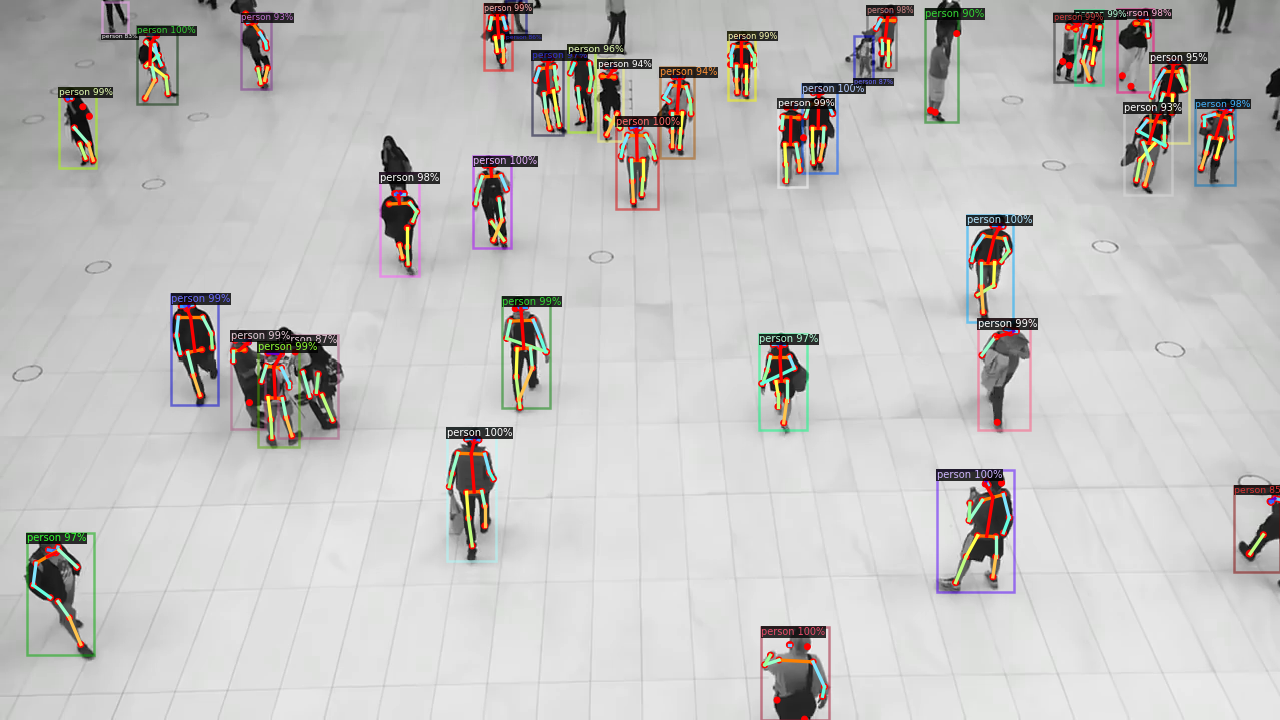

If there occurs any issues with this code fragment, please re-run the Importing Libraries code cell again!


In [7]:
# Inference with a keypoint detection model

#Getting a new confirguration. This is required if we decide to change our model and its weights.
cfg = get_cfg()                                                                    

#Interesting part, this one! With the help of Transfer Learning, we use the Keypoints R-CNN with R-50 Backbone stored in a .yaml file for our dataset! 
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))

#Setting a Threshold. Helps us to determine the extend to which we can balance accuracy vs. errors
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  

#Obtaining the pre-trained model weights. This saves us a ton of time interms of training and testing. Phew! 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

#The below chunk is to visualize our predictions and display it for the first frame (using 0.png)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)                                                            #using the 'im' object here to show results for 0.png frame. 
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

!echo If there occurs any issues with this code fragment, please re-run the Importing Libraries code cell again! 

In [8]:
classes=outputs['instances'].pred_classes.cpu().numpy()                          #To obtain the classes. 0 represent humans, rest is unnecessary here. 
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()                        #To obtain our bounding box co-ordinates. 

relevancy = np.where(classes==0)[0]

#Identify bounding box of Class 0 - people only! 
person = bbox[relevancy]

#Total no. of People at a given frame 
num = len(person) 
print (num)

!echo This is the number of people in the considered frame! 

38
This is the number of people in the considered frame!


In [10]:
import os
import re
  
names=os.listdir('frames_for_keypoints+Bbox/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))                               #Using regex to sort all the images in a proper order. 

In [11]:
#This is a function that iteratively feeds inputs into our 1st model and stores the respective outputs in the same source folder. 
#Confused? After the run is complete, go to frames_for_keypoints+Bbox < 0.png 

#This takes a few mins ... 
def bbox_skeletal(name):  

  img = cv2.imread('frames_for_keypoints+Bbox/'+name)                     
  predictor = DefaultPredictor(cfg)
  outputs = predictor(img)
  v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  im = out.get_image()[:, :, ::-1]
  cv2.imwrite('frames_for_keypoints+Bbox/'+name,im)
  return 0

from tqdm import tqdm                                                             #This library gives a progress bar for the 'for' loop. 
tqdm._instances.clear()                                                           
_ = [bbox_skeletal(names[i]) for i in tqdm(range(len(names)))]

100%|██████████| 340/340 [11:29<00:00,  2.03s/it]


In [12]:
#Re-assembling the images back into a .mp4 video 

#%%time
frames = os.listdir('frames_for_keypoints+Bbox/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames_for_keypoints+Bbox/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('1st_model_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

!echo Check out 1st_model_output.mp4 

Check out 1st_model_output.mp4


##Direct feature extraction from videos without frame splitting


---
#####The below three chunks of code lines were sufficient to device the first model outputs (Or, nearly the same output). But, the FPS taken here implicitly was insufficient for the model to give an accurate prediction. Thus, it's preferable to use the first method. 


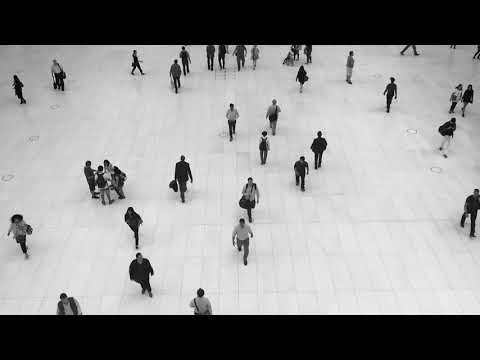

In [ ]:
#Displays the video we've taken i.e., the same one as for the first model. 
from IPython.display import YouTubeVideo, display                                 
video = YouTubeVideo("WvhYuDvH17I", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 10 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python-headless opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://youtu.be/WvhYuDvH17I -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:13 -c:v copy video-clip.mp4                    

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-opencv is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
[youtube] WvhYuDvH17I: Downloading webpage
[download] video.mp4 has already been downloaded
[download] 100% of 2.01MiB
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable

In [ ]:
#!git clone https://github.com/facebookresearch/detectron2
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output Direct_video_extraction.mkv \
  --opts MODEL.WEIGHTS detectron2://ImageNetPretrained/MSRA/R-50.pkl

Failed to load OpenCL runtime
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

[01/19 18:19:53 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-Keypoints/Base-Keypoint-RCNN-FPN.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://ImageNetPretrained/MSRA/R-50.pkl'], output='Direct_video_extraction.mkv', video_input='video-clip.mp4', webcam=False)
[01/19 18:19:59 fvcore.common.checkpoint]: Loading checkpoint from detectron2://ImageNetPretrained/MSRA/R-50.pkl
[01/19 18:19:59 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[01/19 18:19:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branch2a_bn_beta       

##Model 2 -- Social Distance Violation Prediction 


---
#####Here, I extrapolate the outputs from the previous model 1, to include a distance sensitive Bounding Box (Which turns red when social distancing is violated, else remains green). 


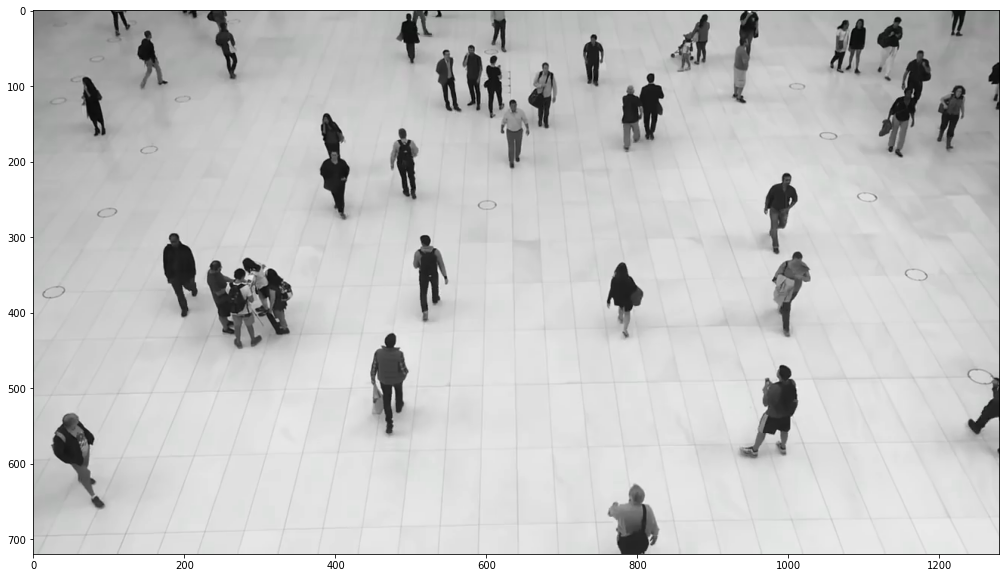

In [14]:
#Just to see the first image! 
img = cv2.imread('frames_for_socialdistance/0.png')
plt.figure(figsize=(20,10))
plt.imshow(img)

In [15]:
classes=outputs['instances'].pred_classes.cpu().numpy()                          #To obtain the classes. 0 represent humans, rest is unnecessary here. 
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()                        #To obtain our bounding box co-ordinates. 

relevancy = np.where(classes==0)[0]

#Identify bounding box of Class 0 - people only! 
person = bbox[relevancy]

#Total no. of People at a given frame 
num = len(person) 
print (num)

!echo This is the number of people in the considered frame! 

38
This is the number of people in the considered frame!


936.84265 470.16238 1013.5186 591.6714


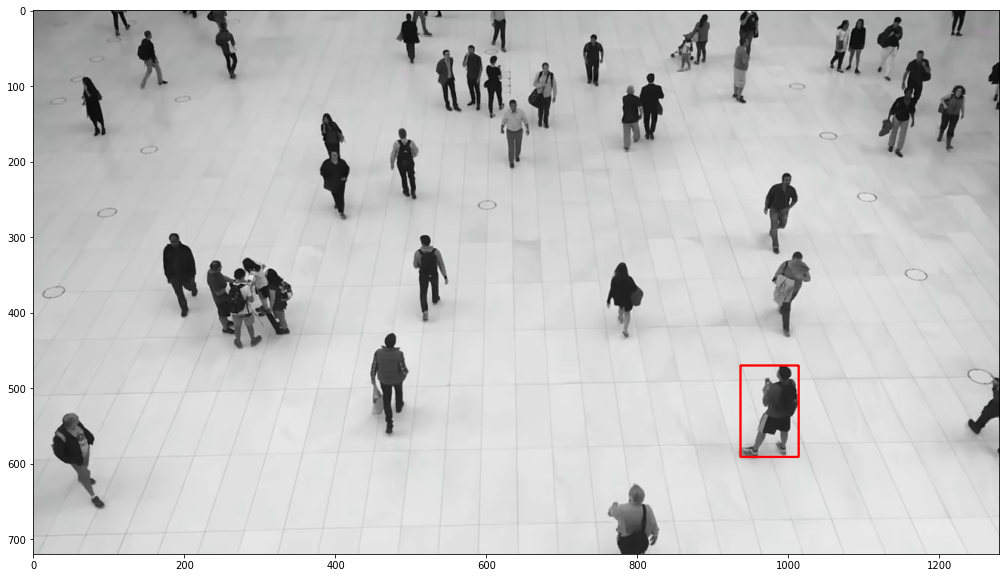

In [16]:
#The bbox coordinates of a single person in the 0th frame and their image. 
#We get a matplotlib plot, to obtain the distance coordinates in an axes system. 

x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

img = cv2.imread('frames_for_socialdistance/0.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

#####The bottom center gives a nearly accurate measure of the coordinate in which a person is present. This is necessary to calculate the distance between any two boxes and thereby, any two people. A threshold value is taken, which when violated, leads to a red box as shown in the above image. 

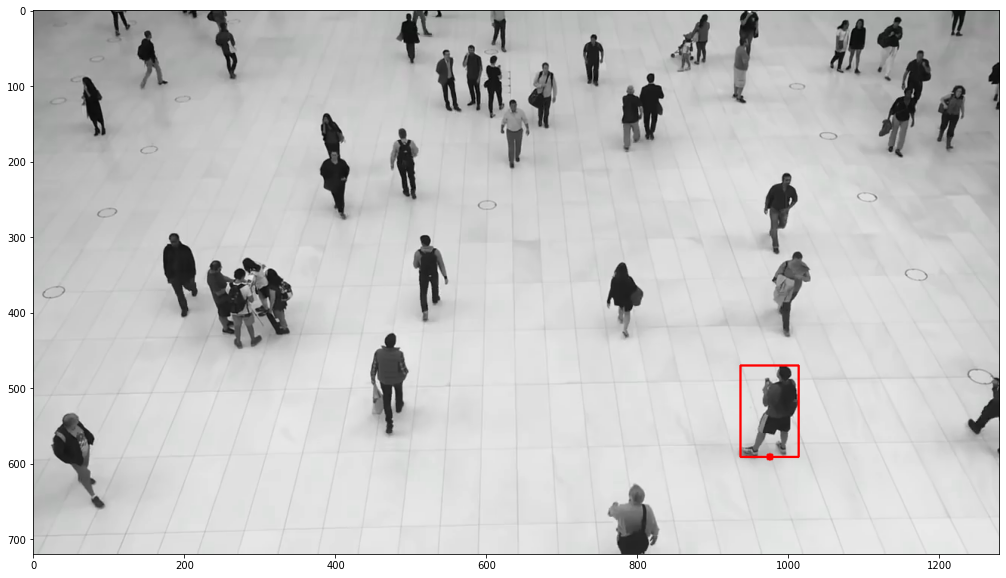

In [17]:
#Computing center co-ordinates  
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

In [18]:
#define a function which return the bottom center of every bbox

def mid_point(img,person,idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (255, 255, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 255, 255), 1, cv2.LINE_AA)
  
  return mid

This is just coded green to visualize. Do not worry, this will be changed soon.


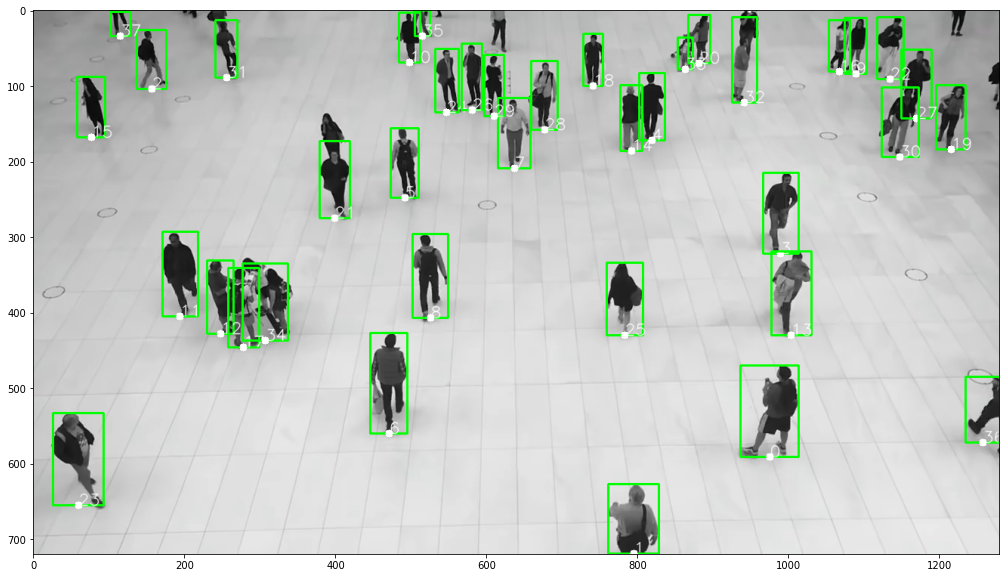

In [19]:
img = cv2.imread('frames_for_socialdistance/0.png')
midpoints = [mid_point(img,person,i) for i in range(len(person))]

#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

!echo This is just coded green to visualize. Do not worry, this will be changed soon. 

In [20]:
#%%time

#This function sums up the crux of our model. It computes the distance between a person and any other person in a frame using the Eucledian theorem ... 
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

In [21]:
dist= compute_distance(midpoints,num)

In [22]:
violation = set()

In [23]:
#%%time

# ... And this function finds the closes ones to flag red, based on the threshold value. 
def find_closest(dist,num,thresh):
  
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        violation.add(i)
        violation.add(j)
        d.append(dist[i][j])
  return p1,p2,d

In [24]:
import pandas as pd

thresh=100                  #This is considered so, because the min. distance required is 1m = 3.2 foot = 100cm.         


p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df.head()

,p1,p2,dist
0,2,37,81.633327
1,4,14,30.413813
2,5,21,96.840074
3,7,26,95.210294
4,7,28,64.815122


In [27]:
def change_2_red(img,person,p1,p2):
  global violation
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2) 
    #violation = violation + 1 
  text1 = "Total Violations : {}".format(len(violation))
  cv2.putText(img, text1, (10, img.shape[0]-55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
  text2 = "Human Count : {}".format(num)
  cv2.putText(img, text2, (10, img.shape[0]-25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255),2)
  return img

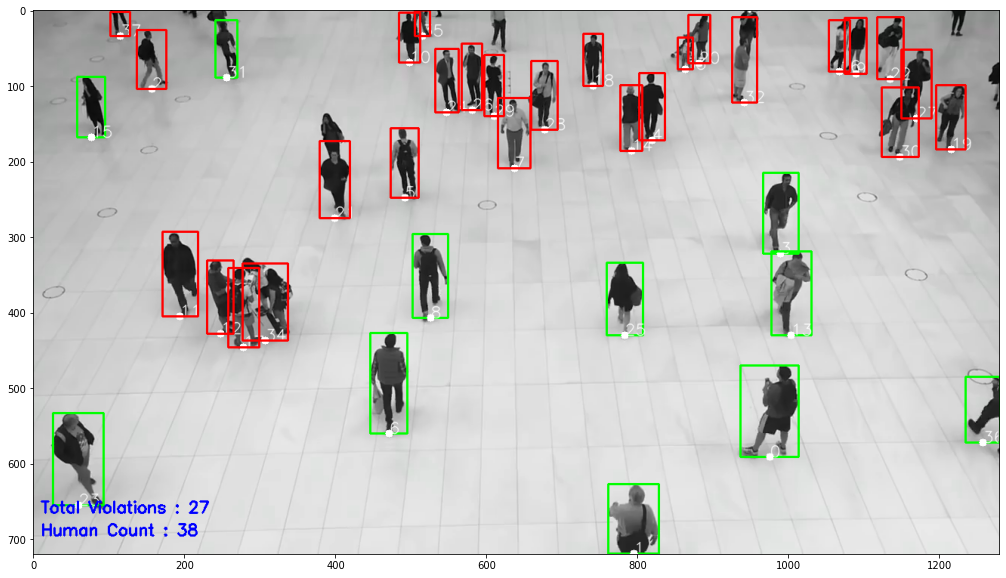

In [28]:
img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [29]:
import os
import re

names=os.listdir('frames_for_socialdistance/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))


def find_closest_people(name,thresh):

  img = cv2.imread('frames_for_socialdistance/'+name)
  outputs = predictor(img)
  classes = outputs['instances'].pred_classes.cpu().numpy()
  bbox = outputs['instances'].pred_boxes.tensor.cpu().numpy()
  relevant = np.where(classes==0)[0]
  person = bbox[relevant]
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  global num
  num = len(midpoints)
  dist = compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)   #thresh = 100 
  img = change_2_red(img,person,p1,p2)
  cv2.imwrite('frames_for_socialdistance/'+name,img)
  return 0

In [30]:
#This takes a few mins ... 

from tqdm import tqdm
tqdm._instances.clear()

thresh=100
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names)))]

100%|██████████| 340/340 [01:28<00:00,  3.83it/s]


In [31]:
#%%time
frames = os.listdir('frames_for_socialdistance/')
frames.sort(key=lambda f: int(re.sub('\D','', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames_for_socialdistance/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('2nd_model_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 25, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

!echo Check out 2nd_model_output.mp4

Check out 2nd_model_output.mp4


##Final Thoughts 

---
This model was designed more on the prototype side rather than a real-time deployment code. Especially, running on a K80, we cannot expect a SOTA processing capability but it gives us a fair and infact, beautiful idea to itegrate many ideas together. 

I was inspired by Andrew Ng's Landing AI team's work on a similar model like this. Though they used a different model, I tried it with the available SOTA model, to be industry relevant. 

One major development I see fit for this model, is to obtain a bird's eye view for highly accurate predictions of distance. But, this involves the constraint of person identification since dots aren't a legible way to distinguish people. Another major inclusion should be the tagging of people throughout their presence with a specific id, rather than changing it frame to frame. This will help in a more accurate violation count. Furthermore, edge-deployments will definitely be fruitful, even after the Covid-19 pandemic, for places like hospitals, queues and other such. 

Also, I encourage playing with different videos. I plan to plug in a few real life ones (from CCTV) too and check for improvements. I will also appreciate your critical comments and suggestions to make this work better. 
